In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import traceback
import re
import pandas.core.algorithms as algos
from pandas import Series
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [72]:
X_train = pd.read_csv('X_train')
y_train = pd.read_csv('y_train')
X_test = pd.read_csv('X_test')
y_test = pd.read_csv('y_test')

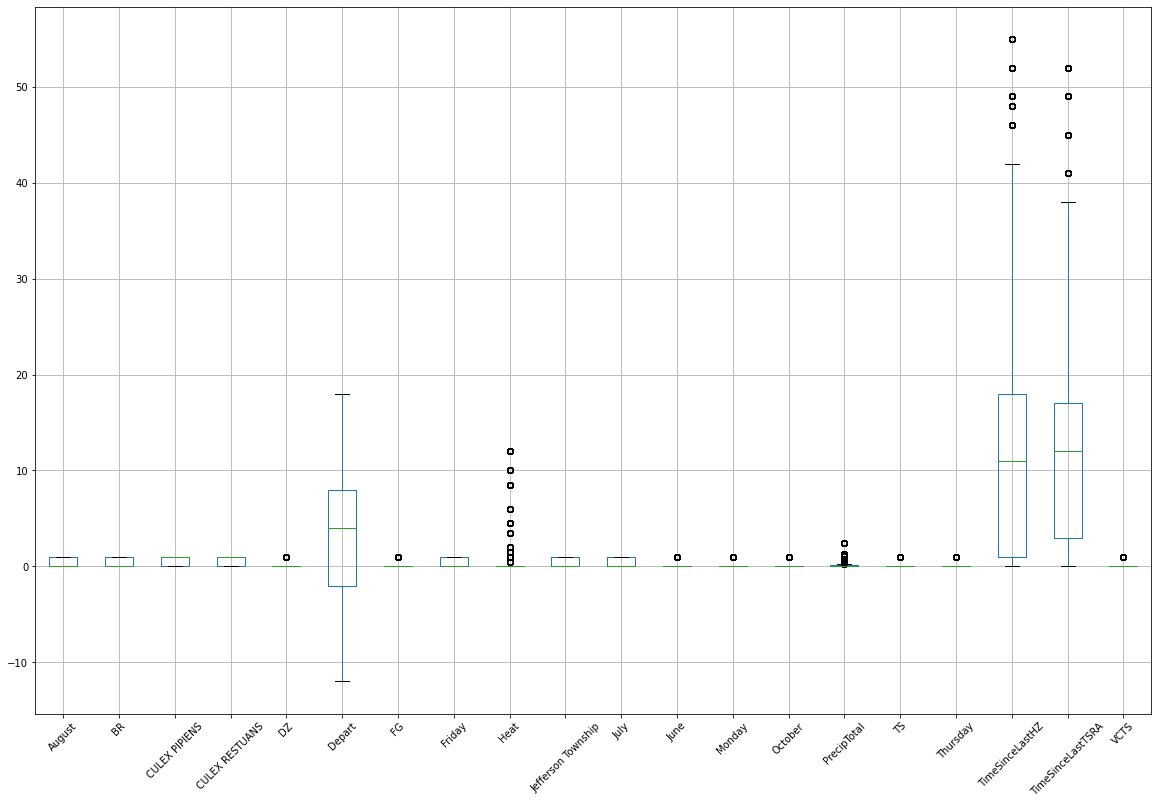

In [73]:
plt.figure(figsize=(20,13))
X_train.boxplot()
plt.xticks(rotation=45);

# Random Forest Model:

In [74]:
#First we need to scale our data before we fit our model.
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_test = X_test[X_train.columns] #This is to match the testing set columns with the ones decided in our previous notebook for the training set.
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [75]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

C:\Users\Smartjuice\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Features [0.11313049 0.02962386 0.08692445 0.12892421 0.00611679 0.0871062
 0.0268398  0.0176363  0.00623386 0.15163817 0.01692166 0.02084456
 0.00383966 0.00127484 0.04960507 0.02325851 0.01805836 0.08061545
 0.12701864 0.00438912]


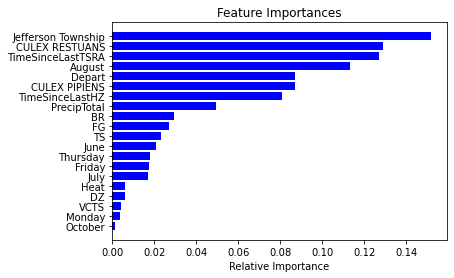

Random Forest: Accuracy=0.948
Random Forest: F1 Score=0.924
Random Forest: ROC Score=0.509


In [76]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 50, random_state = 42, max_depth=50)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

print("Features",clf.feature_importances_)

importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc1 = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: F1 Score=%.3f' % (f1))

print('Random Forest: ROC Score=%.3f' % (roc1))

In [77]:
cm

array([[2984,    2],
       [ 163,    3]], dtype=int64)

In [63]:
y_test

,WnvPresent
0,0
1,0
2,1
3,0
4,0
...,...
3147,0
3148,0
3149,0
3150,0


# XG Boost Model:

In [53]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_model = xgb.fit(X_train,y_train)
y_pred2 = xgb_model.predict(X_test)

ac_xgb = accuracy_score(y_test, y_pred2)
f1_xgb = f1_score(y_test, y_pred2, average='weighted')
cm_xgb = confusion_matrix(y_test, y_pred2)
roc_xgb = roc_auc_score(y_test, y_pred2)


print('XG Boost: Accuracy=%.3f' % (ac_xgb))
print('XG Boost: f1-score=%.3f' % (f1_xgb))
print('XG Boost: ROC Score=%.3f' % (roc_xgb))

[20:53:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG Boost: Accuracy=0.946
XG Boost: f1-score=0.922
XG Boost: ROC Score=0.502


C:\Users\Smartjuice\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Smartjuice\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Smartjuice\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=

In [41]:
predictions = [round(value) for value in y_pred2]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.64%


In [42]:
cm_xgb

array([[2982,    4],
       [ 165,    1]], dtype=int64)

In [27]:
X_test

,August,BR,DZ,Depart,FG,Friday,Heat,Jefferson Township,July,June,Monday,October,PrecipTotal,TS,Thursday,TimeSinceLastHZ,TimeSinceLastTSRA,VCTS
0,0,1,0,-9.0,0,0,8.5,0,0,1,0,0,0.345,0,0,7.0,7.0,0
1,1,0,0,-7.0,0,0,0.0,0,0,0,0,0,0.000,0,1,49.0,38.0,0
2,0,0,0,0.0,0,0,0.0,0,1,0,1,0,0.025,0,0,17.0,3.0,0
3,0,0,0,7.0,0,1,0.0,0,0,1,0,0,0.000,0,0,11.0,4.0,0
4,0,1,0,0.0,0,1,0.0,1,1,0,0,0,0.100,0,0,0.0,18.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,1,0,0,8.0,0,0,0.0,0,0,0,0,0,0.000,0,1,0.0,15.0,0
3148,0,0,0,0.0,0,0,0.0,1,1,0,1,0,0.025,0,0,17.0,3.0,0
3149,0,0,0,10.0,0,0,0.0,0,0,0,1,0,0.000,0,0,10.0,45.0,0
3150,1,0,0,3.0,0,1,0.0,0,0,0,0,0,0.005,0,0,25.0,7.0,0
